# Part 1

# Solution
1a) w1 = -2.04427331  w2 = 3.99683416 b = -0.92427055

1b) Levenberg–Marquardt as per implementation below

In [1]:
#%%
import os
import numpy as np
import scipy.io
import scipy.optimize as optimization
#from IPython.core.debugger import set_trace

# Data
filedir = os.path.dirname(os.path.realpath('__file__'))
datapath = os.path.join(filedir,'assign1_data.mat')
data = scipy.io.loadmat(datapath)

# fitter wants shape (k,M) (k number of predictors)
# data['x'] has shape (M,k) so we fix that
x1 = data['x'][:,0]
x2 = data['x'][:,1]
X = np.array([x1,x2])
# argg - shape (100,1) - gives obstuse error in the fitter
# we fix that too (flatten)
y = np.array(data['y']).flatten()

# Initial guess
w0 = np.array([1, 1, 1])

# Objective function
# y = w1 * x1 + w2 * x2 + b.
def func(X, b, w1, w2):
  # unpack independent vars
  rval = w1*X[0] + w2*X[1] + b
  return rval

result = optimization.curve_fit(func, X, y, w0)
print(result[0])

[-0.92427055 -2.04427331  3.99683416]


## Part 2

In [2]:
import os
import numpy as np
import scipy.io
import scipy.optimize as optimization
#from IPython.core.debugger import set_trace

EPS = 0.001
N_EPOCH = 1000
def dw(w,d,X):
    # using numpy einstein summation to vectorize the computation
    # vector of coefficients (d-w.x) for each pattern (alpha)     
    C = d - np.einsum('i,ij->j', w, X) # shape is (100,)
    # C_i * X_ji or C * transpose(X)
    dw = EPS*np.einsum('i,ji->j', C, X) # shape is (3,)
    return dw

def main():
    # data
    filedir = os.path.dirname(os.path.realpath('__file__'))
    datapath = os.path.join(filedir,'assign1_data.mat')
    data = scipy.io.loadmat(datapath)
    x1 = data['x'][:,0]
    x2 = data['x'][:,1]
    # inputs - with bias input tied high, shape is (3,100)
    X = np.array([np.full(len(x1),1),x1,x2])
    # output
    d = np.array(data['y']).flatten()
    # starting vector of weights
    w = [1,1,1]

    for _ in range(N_EPOCH):
        w = w + dw(w,d,X)
    print(w)

# invoke main
main()

[-0.92233149 -2.0427036   3.99155586]


## Part 3

In [3]:
import os as os
import numpy as np
import scipy.io
import scipy.optimize as optimization
from IPython.core.debugger import set_trace

N_EPOCH = 30

n_mis = []
def dwp(w,d,X):
    # using numpy einstein summation to vectorize the computation
    # calculating w.x.d -- w.x.d < 0 => incorrect classification
    C = d*np.einsum('i,ij->j', w, X) # shape is (100,)
    XT = X.transpose()
    # use enumerate for the equivalent to each_with_index (Ruby)
    xd = [ d[i]*XT[i] for i,c in enumerate(C) if c < 0]
    # for N vs EPOCH plot
    n_mis.append(len(xd))
    # sum xd element-wise
    # dw is x.t summed over misclassified teachers
    dw = np.einsum('ij->j',xd) # shape is (3,)
    return dw

def main():
    # data
    filedir = os.path.dirname(os.path.realpath('__file__'))
    datapath = os.path.join(filedir,'assign1_data.mat')
    data = scipy.io.loadmat(datapath)
    x1 = data['x'][:,0]
    x2 = data['x'][:,1]
    # inputs - with bias input tied high, shape is (3,100)
    X = np.array([np.full(len(x1),1),x1,x2])
    XT = X.transpose();
    # output
    d = np.array(data['z']).flatten()
    # use domain -1,1 for teachers so we can use x.w.d<0 for the classification test
    d = [z if z == 1 else -1 for z in d]
    # starting vector of weights
    w = [1,1,1]
    # sweep through the data N_EPOCH times
    for _ in range(N_EPOCH):
        w = w + dwp(w,d,X)
    
    return w

# invoke main
w_perceptron = main()
print(w_perceptron)
print(n_mis)

[-16.         -50.43661604  81.86640442]
[45, 55, 45, 55, 45, 47, 45, 24, 33, 40, 41, 28, 21, 9, 5, 5, 5, 4, 5, 3, 5, 5, 4, 5, 5, 5, 4, 5, 4, 5]


# Visualization of perceptron results

Read the data into a panda dataframe for visualization

In [4]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

import pandas as pd

def load_data():
    csv_path = os.path.join(".", "assign1_data.txt")
    return pd.read_csv(csv_path, sep="\s+")

def load_data():
    csv_path = os.path.join(".", "assign1_data.txt")
    return pd.read_csv(csv_path, sep="\s+")

data = load_data()
data.head()
c0 = data[(data.z==0)]
c1 = data[(data.z==1)]


### HW data in parameter space with classification indicated by color

The plotted line is the surface of separation given by 
x2 = -1/w2(w1x1 + w0) where w is the weight vector calculated using perceptron algorithm.  As is indicated in the figure the data is not linearly seperable so the perceptron algorithm does not converge, instead it jitters around near the minimum.

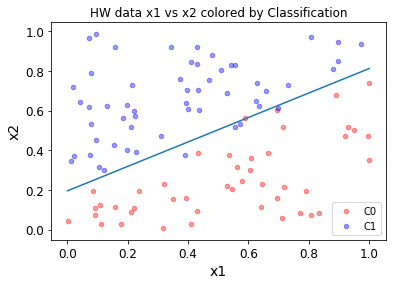

In [5]:
X = np.linspace(0, 1, 128, endpoint=True)
W = w_perceptron
L = -(1/W[2])*(W[1]*X + W[0])

ax = c0.plot.scatter(x="x1", y="x2", color='Red', alpha=0.4, label='C0')
c1.plot.scatter( x="x1", y="x2", color='Blue', alpha=0.4, label='C1', ax=ax)
ax.plot(X,L)
plt.title('HW data x1 vs x2 colored by Classification')


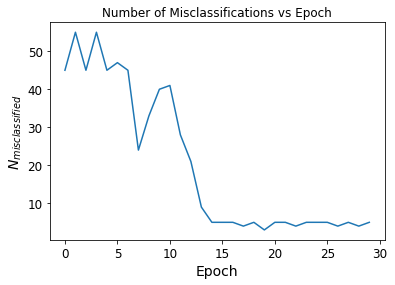

In [6]:
plt.ylabel(r'$N_{misclassified}$')
plt.xlabel('Epoch')
plt.title('Number of Misclassifications vs Epoch')
plt.plot(n_mis)